In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from target import build_tgt_matrix
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [61]:
session = selected_009266[8]
all_areas = ['A1', 'PPC', 'HPC']

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5_file     = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, 'PSTH', session)
if not os.path.exists(report_path):
    os.makedirs(report_path)
session

'009266_hippoSIT_2023-05-04_19-47-15'

In [62]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])

envelopes = {}
with h5py.File(aeps_file, 'r') as f:
    for area in all_areas:
        if not area in f:
            continue
        envelopes[area] = np.array(f[area]['LFP4Hz']['envelope'])
    aeps_events = np.array(f['aeps_events'])
    
areas = list(envelopes.keys())

In [63]:
# get available units
unit_names = []
with h5py.File(h5_file, 'r') as f:
    unit_names = [x for x in f['units']]
            
print(unit_names)

['1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17', '1-18', '1-19', '1-2', '1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1-26', '1-27', '1-28', '1-29', '1-3', '1-30', '1-31', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-10', '2-11', '2-12', '2-13', '2-14', '2-15', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '3-8', '4-2', '4-3', '4-4', '4-5', '4-6', '4-7', '4-8', '5-2', '6-2', '6-3', '6-4']


In [64]:
# read single units
single_units = {}
spike_times = {}

with h5py.File(h5_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        #single_units[unit_name] = instantaneous_rate(unit_times, tl[:, 0], k_width=50)

## CCR between LFP 4Hz and Units

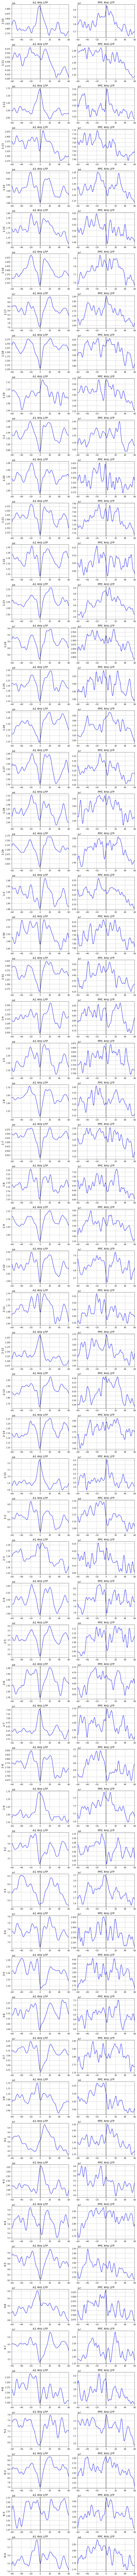

In [65]:
s_rate  = 100
t_lag   = 60  # seconds
columns = len(areas)
rows    = len(single_units)

fig = plt.figure(figsize=(10, 3*rows))

for i, (unit_name, i_rate) in enumerate(single_units.items()):
    for j, area in enumerate(areas):
        metric1 = envelopes[area][::10][:len(tl)]  # downsample from 1KHz to 100Hz
        metric2 = i_rate

        corr = signal.correlate(metric1, metric2)
        lags = signal.correlation_lags(len(metric2), len(metric1))
        idx_l, idx_r = int(len(lags)/2) - t_lag*s_rate, int(len(lags)/2) + t_lag*s_rate

        ax = fig.add_subplot(rows, columns, i*columns + j+1)
        ax.plot(lags[idx_l:idx_r]/s_rate, corr[idx_l:idx_r], color='blue')

        if j == 0:
            ax.set_ylabel(unit_name, fontsize=14)
        ax.set_title("%s 4Hz LFP" % area, fontsize=14)
        ax.axvline(0, color='black')
        ax.set_xlim(-t_lag, t_lag)
        ax.grid()

fig.tight_layout()
fig.savefig(os.path.join(report_path, 'CCR_LFP4Hz_units.pdf'))